# Label Spreading

**Label Spreading** es un algoritmo de **aprendizaje semi-supervisado basado en grafos**. Es una versión suavizada de [[Label Propagation]], que introduce regularización para hacer la propagación más estable y robusta ante errores en las etiquetas.

---

La idea central es que **puntos de datos similares deberían tener etiquetas similares**. Se parte de un conjunto pequeño de datos etiquetados y muchos sin etiquetar. Las etiquetas se propagan a través de un grafo de similitud, pero de forma más **controlada** que en **Label Propagation**.

---

## Fundamento teórico

Dado un conjunto:

$X = \{x_1, x_2, ..., x_n\}$
- $X$: conjunto **total** de instancias (etiquetadas y no etiquetadas).
- $L \subset X$: subconjunto de $X$ con **etiquetas conocidas**.
- $U$: subconjunto de $X$ **sin etiquetas**, es el **complemento de $L$ dentro de $X$**

Se construye un grafo no dirigido $G = (V, E)$ con pesos de similitud entre nodos.
- $V$ — Conjunto de vértices (nodos)
- $E$ — Conjunto de aristas

---

## Matriz de similitud

Se define la **matriz de similitud $W$** como:

$$
w_{ij} = \exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma^2}\right)
$$

También puede construirse con vecinos más cercanos [[K-Nearest Neighbors]].

Luego se normaliza para obtener la **matriz de propagación $S$**:

$$
S = D^{-1/2} W D^{-1/2}
$$

Donde $D_{ii} = \sum_j w_{ij}$ es la matriz diagonal de grados.

---

## Algoritmo

Se inicia con:

- Una matriz $Y$ que contiene las etiquetas conocidas (one-hot)
- Una matriz $F$ que se actualizará en cada iteración

La actualización sigue la regla:

$$
F_{t+1} = \alpha S F_t + (1 - \alpha) Y
$$

Donde:

- $F_t$ es la matriz de etiquetas en el paso $t$
- $\alpha \in (0, 1)$ es un parámetro de mezcla
- $Y$ son las etiquetas iniciales

Se itera hasta que $F$ converge.

---

## Parámetro $\alpha$

- Si $\alpha \approx 1$: se favorece la propagación
- Si $\alpha \approx 0$: se conserva más la etiqueta original

**Seudo-etiquetas**. A diferencia de **Label Propagation**, aquí las etiquetas originales no se fijan totalmente, sino que se permiten ajustes.

---

## Comparación con Label Propagation

| Aspecto                        | Label Propagation       | Label Spreading           |
|--------------------------------|--------------------------|----------------------------|
| Fijación de etiquetas          | Sí                      | No                         |
| Regularización                 | No                      | Sí                         |
| Estabilidad                   | Menor                   | Mayor                      |
| Ecuación                      | $F_{t+1} = T F_t$        | $F_{t+1} = \alpha S F_t + (1 - \alpha) Y$ |

---

## Ventajas

- Mayor **estabilidad**
- Robusto frente a **ruido en las etiquetas**
- Ajustable vía parámetro $\alpha$

---

## Limitaciones

- Sigue siendo **transductivo** (no generaliza a nuevos datos)
- Depende de la construcción del grafo
- Necesita calibrar bien los hiperparámetros ($\alpha$, kernel, vecinos, etc.)


## Ejemplo

Nodos:

| Nodo | Etiqueta inicial | 
|------|------------------|
| A    | 0                |
| B    | ?                |
| C    | ?                | 
| D    | 1                | 
| E    | ?                | 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Nombres de nodos
nodos = ['A', 'B', 'C', 'D', 'E']

# 1. Coordenadas de los puntos (2D)
X = np.array([
    [0.0, 1.0],  # A
    [1.0, 1.0],  # B
    [1.0, 0.0],  # C
    [2.0, 1.0],  # D
    [2.0, 0.0],  # E
])

# 2. Etiquetas iniciales (one-hot: 2 clases), -1 indica sin etiqueta
# A -> clase 0, D -> clase 1
Y = np.zeros((5, 2))
Y[0, 0] = 1  # A
Y[3, 1] = 1  # D

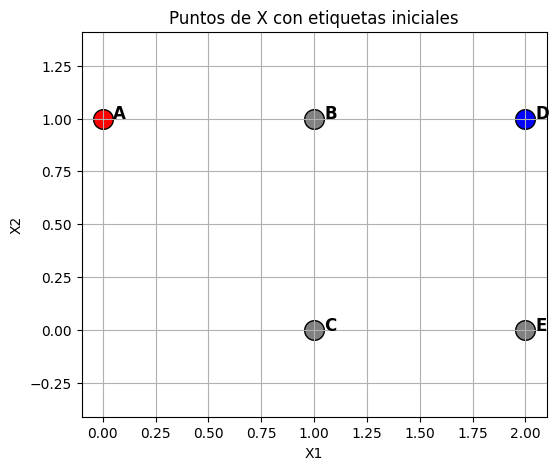

In [3]:
etiquetas_iniciales = np.array([0, -1, -1, 1, -1])
colores = []
for y in etiquetas_iniciales:
    if y == 0:
        colores.append('red')
    elif y == 1:
        colores.append('blue')
    else:
        colores.append('gray')

# Graficar
plt.figure(figsize=(6, 5))
for i, nombre in enumerate(nodos):
    plt.scatter(X[i, 0], X[i, 1], color=colores[i], s=200, edgecolor='black')
    plt.text(X[i, 0] + 0.05, X[i, 1], nombre, fontsize=12, weight='bold')

plt.title("Puntos de X con etiquetas iniciales")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.axis('equal')
#plt.axis('off')
plt.show()

In [4]:
# 3. Construcción de matriz de similitud con kernel Gaussiano
sigma = 1.0
n = X.shape[0]
W = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:
            dist = np.linalg.norm(X[i] - X[j])
            W[i, j] = np.exp(-dist**2 / (2 * sigma**2))

In [5]:
# 4. Matriz de grado y normalización simétrica
D = np.diag(np.sum(W, axis=1))
D_sqrt_inv = np.diag(1.0 / np.sqrt(np.sum(W, axis=1)))
S = D_sqrt_inv @ W @ D_sqrt_inv

In [6]:
# 5. Iteración de Label Spreading
alpha = 0.8
F = Y.copy()
for _ in range(100):
    F_new = alpha * S @ F + (1 - alpha) * Y
    if np.allclose(F, F_new, atol=0.0001):
        break
    F = F_new

In [7]:
# 6. Predicción final
predicciones = np.argmax(F, axis=1)
resultado = pd.DataFrame({
    'Nodo': nodos,
    'Clase 0 (prob)': F[:, 0],
    'Clase 1 (prob)': F[:, 1],
    'Etiqueta predicha': predicciones
})

print (resultado)

  Nodo  Clase 0 (prob)  Clase 1 (prob)  Etiqueta predicha
0    A        0.294851        0.122286                  0
1    B        0.171862        0.187187                  1
2    C        0.148086        0.168715                  1
3    D        0.122286        0.333774                  1
4    E        0.115310        0.175965                  1


## Paqueteria de Python que implementa Label Spreading

In [8]:
from sklearn.semi_supervised import LabelSpreading

Etiquetas predichas: [0 1 1 1 1]


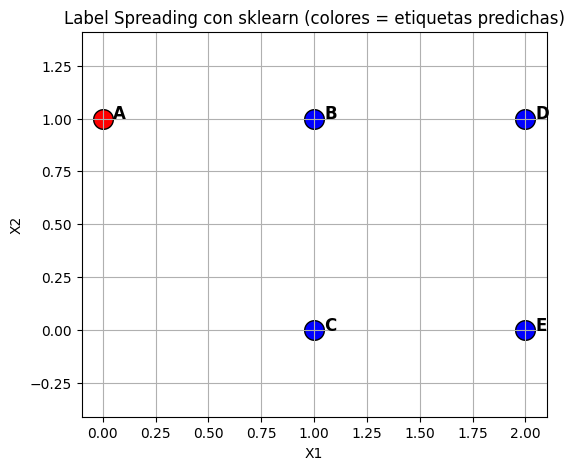

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.semi_supervised import LabelSpreading

# Datos del ejemplo (coordenadas de los nodos)
X = np.array([
    [0.0, 1.0],  # A
    [1.0, 1.0],  # B
    [1.0, 0.0],  # C
    [2.0, 1.0],  # D
    [2.0, 0.0],  # E
])

# Etiquetas: 0 para A, 1 para D, -1 para los demás
y = np.array([0, -1, -1, 1, -1])

# Crear y ajustar el modelo
model = LabelSpreading(kernel='rbf', gamma=0.5, alpha=0.8, max_iter=1000)
#model = LabelSpreading(kernel='knn', gamma=0.5, alpha=0.8, max_iter=1000)

model.fit(X, y)

# Etiquetas predichas
predicted = model.transduction_

print("Etiquetas predichas:", predicted)

# Graficar puntos con color según etiqueta predicha
colors = ['red' if label==0 else 'blue' for label in predicted]
labels_name = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(6,5))
for i, name in enumerate(labels_name):
    plt.scatter(X[i, 0], X[i, 1], color=colors[i], s=200, edgecolor='black')
    plt.text(X[i, 0]+0.05, X[i, 1], name, fontsize=12, weight='bold')
plt.title("Label Spreading con sklearn (colores = etiquetas predichas)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.axis('equal')
plt.show()
